In [1]:
import numpy as np
import librosa
import soundfile as sf
from scipy.fftpack import dct, idct
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


def load_audio(file_path, target_sr=44100):
    """
    Load an audio file and resample to target sample rate.
    
    Parameters:
    - file_path: Path to the audio file.
    - target_sr: Target sample rate in Hz.
    
    Returns:
    - audio: Numpy array of audio samples.
    - sr: Sample rate of the loaded audio.
    """
    audio, sr = librosa.load(file_path, sr=target_sr, mono=True)
    return audio, sr

def save_audio(file_path, audio, sr):
    """
    Save an audio array to a file.
    
    Parameters:
    - file_path: Path where the audio will be saved.
    - audio: Numpy array of audio samples.
    - sr: Sample rate in Hz.
    """
    sf.write(file_path, audio, sr)

def embed_secret_into_cover(cover, secret, alpha=0.1):
    """
    Embed secret audio into cover audio using DCT.
    
    Parameters:
    - cover: Numpy array of cover audio samples.
    - secret: Numpy array of secret audio samples.
    - alpha: Embedding strength factor.
    
    Returns:
    - stego: Numpy array of stego-audio samples.
    """
    # Perform DCT on cover and secret
    cover_dct = dct(cover, norm='ortho')
    secret_dct = dct(secret, norm='ortho')

    # Ensure the secret is not longer than the cover
    min_length = min(len(cover_dct), len(secret_dct))
    cover_dct[:min_length] += alpha * secret_dct[:min_length]

    # Perform inverse DCT to get stego audio
    stego = idct(cover_dct, norm='ortho')
    # Normalize to prevent clipping
    stego = np.clip(stego, -1.0, 1.0)
    return stego

def extract_secret_from_stego(stego, cover, alpha=0.1):
    """
    Extract secret audio from stego audio using DCT.
    
    Parameters:
    - stego: Numpy array of stego-audio samples.
    - cover: Numpy array of original cover audio samples.
    - alpha: Embedding strength factor used during embedding.
    
    Returns:
    - secret_extracted: Numpy array of extracted secret audio samples.
    """
    # Perform DCT on stego and cover
    stego_dct = dct(stego, norm='ortho')
    cover_dct = dct(cover, norm='ortho')

    # Extract secret DCT coefficients
    secret_extracted_dct = (stego_dct - cover_dct) / alpha

    # Perform inverse DCT to get extracted secret audio
    secret_extracted = idct(secret_extracted_dct, norm='ortho')
    # Normalize to prevent clipping
    secret_extracted = np.clip(secret_extracted, -1.0, 1.0)
    return secret_extracted

def calculate_metrics(original, modified):
    """
    Calculate MSE and SNR between original and modified signals.
    
    Parameters:
    - original: Numpy array of original audio samples.
    - modified: Numpy array of modified audio samples.
    
    Returns:
    - mse: Mean Squared Error.
    - snr: Signal-to-Noise Ratio in dB.
    """
    mse = mean_squared_error(original, modified)
    # To calculate SNR, prevent division by zero
    if mse == 0:
        snr = float('inf')
    else:
        snr = 10 * np.log10(np.mean(original**2) / mse)
    return mse, snr

def plot_waveforms(original, modified, title1='Original', title2='Modified'):
    """
    Plot two waveforms for comparison.
    
    Parameters:
    - original: Numpy array of original audio samples.
    - modified: Numpy array of modified audio samples.
    - title1: Title for the first plot.
    - title2: Title for the second plot.
    """
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(original)
    plt.title(title1)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.subplot(1, 2, 2)
    plt.plot(modified)
    plt.title(title2)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

def plot_spectrogram(audio, sr, title='Spectrogram'):
    """
    Plot the spectrogram of an audio signal.
    
    Parameters:
    - audio: Numpy array of audio samples.
    - sr: Sample rate of the audio.
    - title: Title for the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.specgram(audio, Fs=sr, NFFT=2048, noverlap=1024, cmap='viridis')
    plt.title(title)
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')
    plt.colorbar(label='Intensity [dB]')
    plt.show()

def calculate_rms(audio):
    """
    Calculate the Root Mean Square (RMS) of the audio signal.
    
    Parameters:
    - audio: Numpy array of audio samples.
    
    Returns:
    - rms: RMS value of the audio.
    """
    return np.sqrt(np.mean(audio**2))

def plot_rms(cover, stego, secret_extracted):
    """
    Plot the RMS energy comparison of cover, stego, and extracted secret audio.
    
    Parameters:
    - cover: Numpy array of cover audio samples.
    - stego: Numpy array of stego audio samples.
    - secret_extracted: Numpy array of extracted secret audio samples.
    """
    rms_cover = calculate_rms(cover.flatten())
    rms_stego = calculate_rms(stego.flatten())
    rms_extracted = calculate_rms(secret_extracted.flatten())
    
    labels = ['Cover Audio', 'Stego Audio', 'Extracted Secret']
    rms_values = [rms_cover, rms_stego, rms_extracted]
    
    plt.figure(figsize=(8, 5))
    plt.bar(labels, rms_values, color=['blue', 'orange', 'green'])
    plt.title('RMS Energy Comparison')
    plt.ylabel('RMS Value')
    plt.show()

def overlay_waveforms(cover, stego):
    """
    Overlay the waveforms of cover and stego audio for comparison.
    
    Parameters:
    - cover: Numpy array of cover audio samples.
    - stego: Numpy array of stego audio samples.
    """
    plt.figure(figsize=(14, 5))
    plt.plot(cover.flatten(), label='Cover Audio', alpha=0.6)
    plt.plot(stego.flatten(), label='Stego Audio', alpha=0.6)
    plt.title('Waveform Overlay: Cover vs Stego Audio')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

def plot_histogram(audio, title='Amplitude Histogram'):
    """
    Plot the histogram of the audio amplitude values.
    
    Parameters:
    - audio: Numpy array of audio samples.
    - title: Title for the plot.
    """
    plt.figure(figsize=(10, 5))
    plt.hist(audio.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(title)
    plt.xlabel('Amplitude')
    plt.ylabel('Frequency')
    plt.xlim([-1, 1])
    plt.show()

def plot_correlation(cover, stego):
    """
    Plot the correlation between cover and stego audio.
    
    Parameters:
    - cover: Numpy array of cover audio samples.
    - stego: Numpy array of stego audio samples.
    """
    correlation = np.corrcoef(cover.flatten(), stego.flatten())[0, 1]
    
    plt.figure(figsize=(8, 5))
    plt.scatter(cover.flatten(), stego.flatten(), alpha=0.5)
    plt.title(f'Cover vs Stego Correlation (r={correlation:.2f})')
    plt.xlabel('Cover Audio Amplitude')
    plt.ylabel('Stego Audio Amplitude')
    plt.axline((0, 0), slope=1, color='red', linestyle='--')
    plt.grid()
    plt.show()


Loading audio files...
Embedding secret into cover...
Saving stego audio...
Extracting secret from stego...
Saving extracted secret audio...
Mean Squared Error (MSE): 6.783453159187047e-07
Signal-to-Noise Ratio (SNR): 43.525404930114746 dB


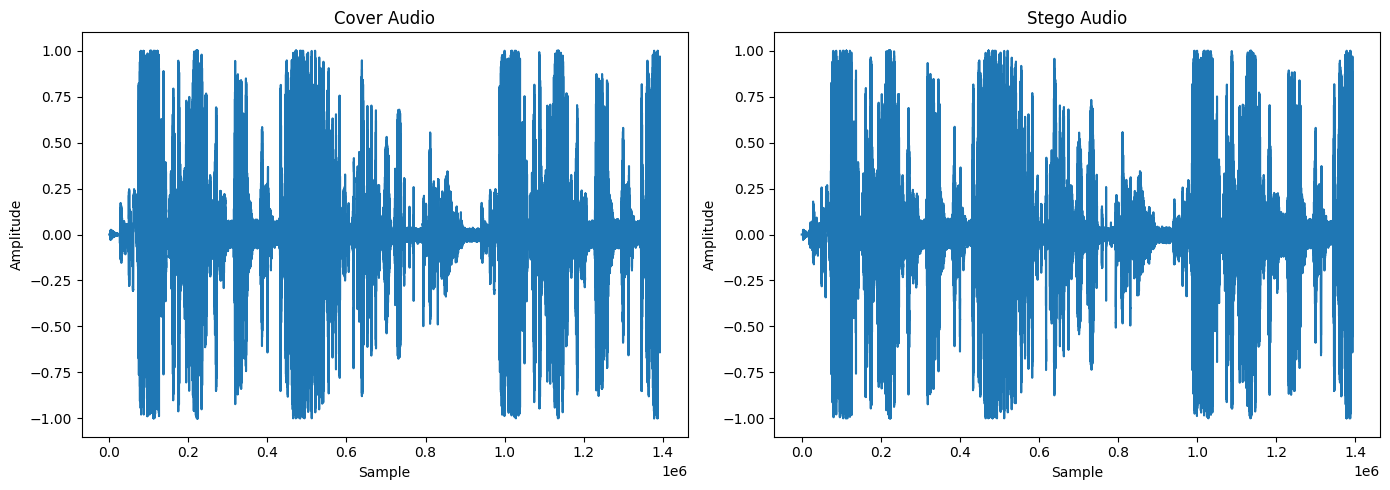

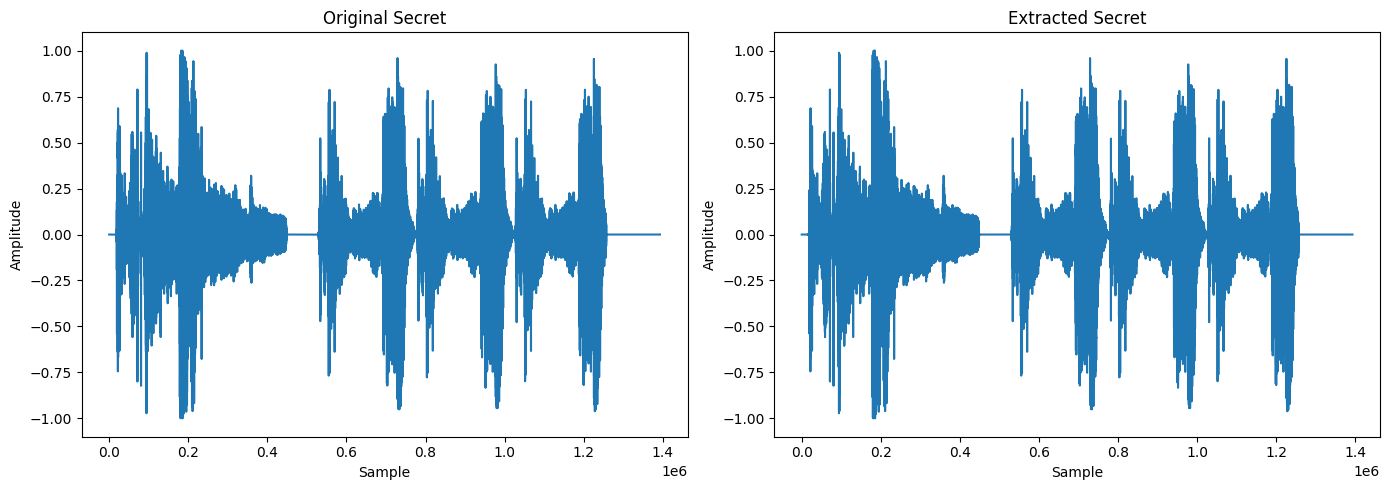

c:\Users\ranaa\anaconda3\envs\Tensorflow\lib\site-packages\matplotlib\axes\_axes.py:8089: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


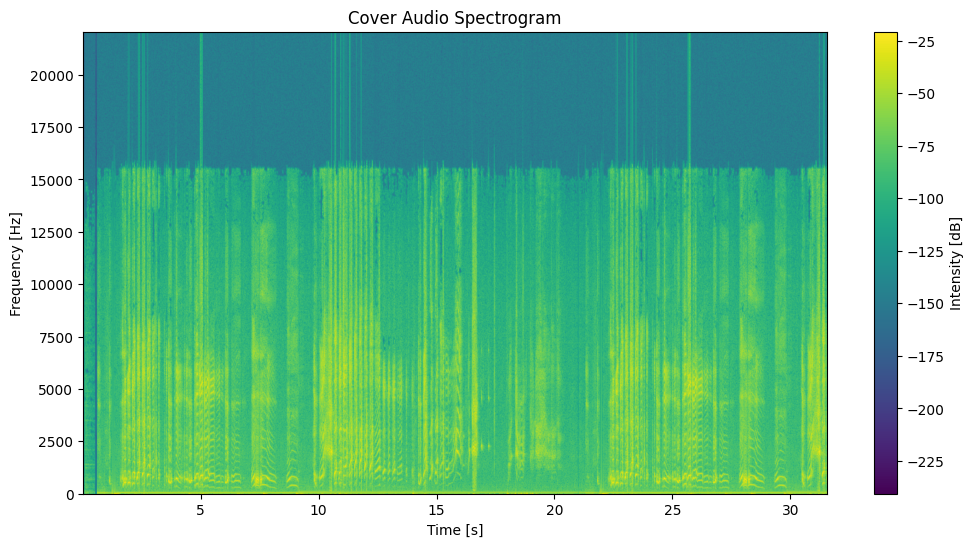

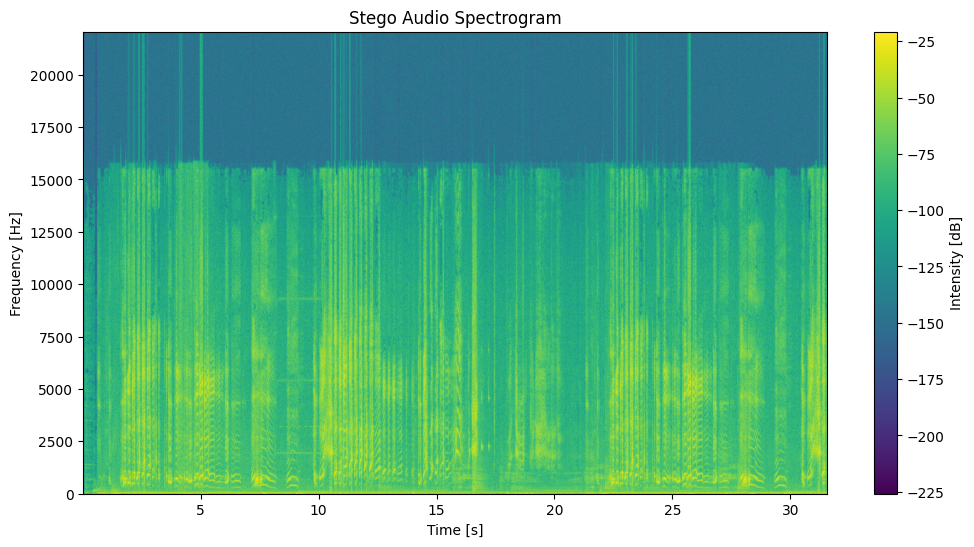

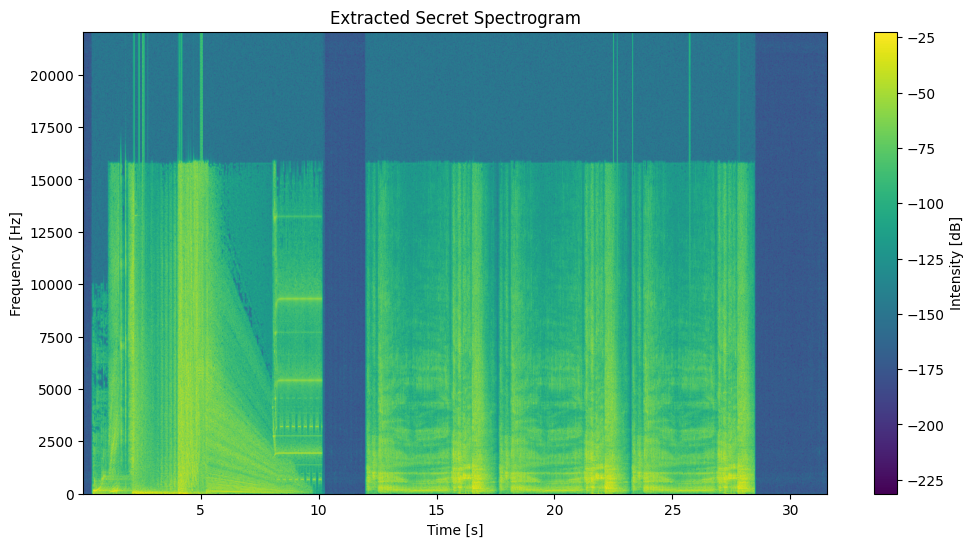

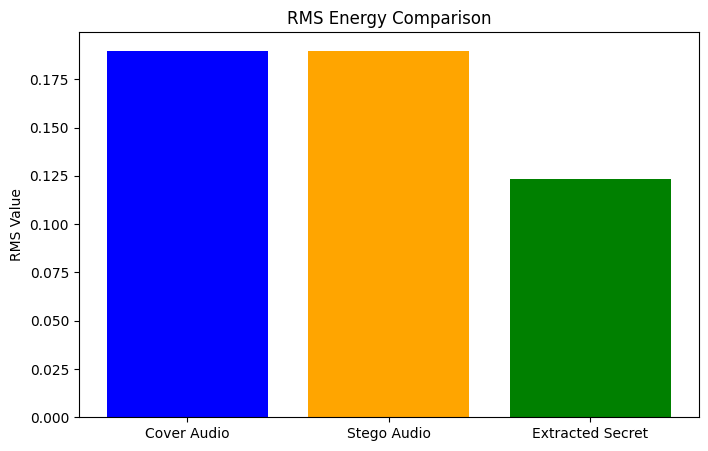

c:\Users\ranaa\anaconda3\envs\Tensorflow\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


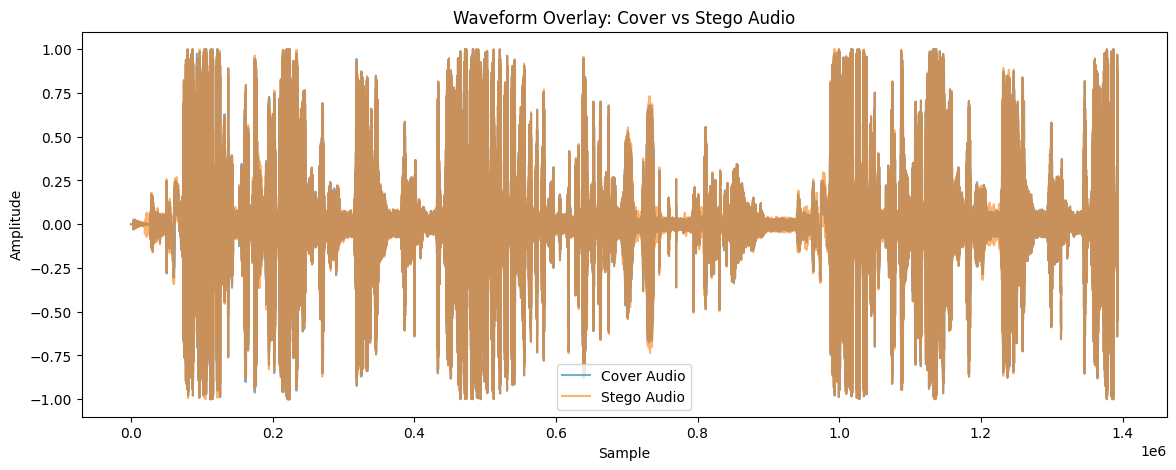

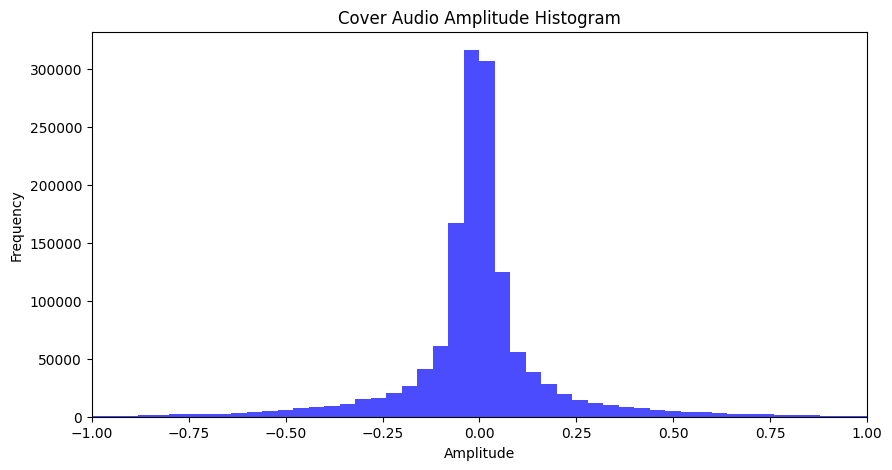

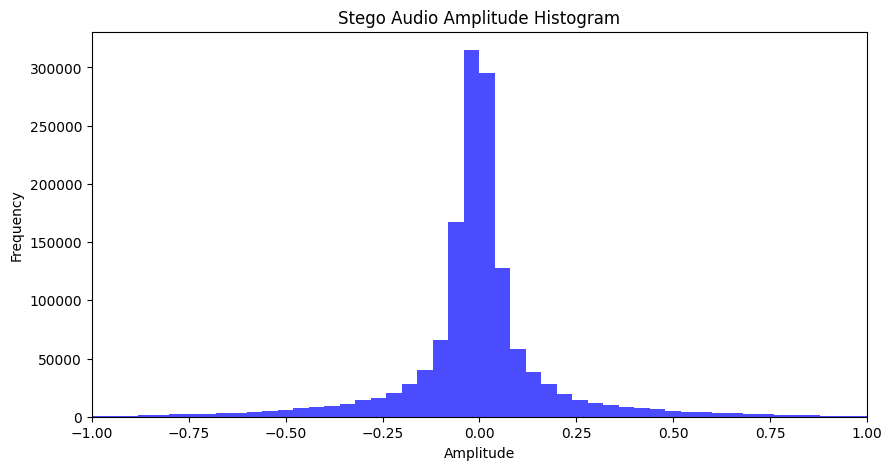

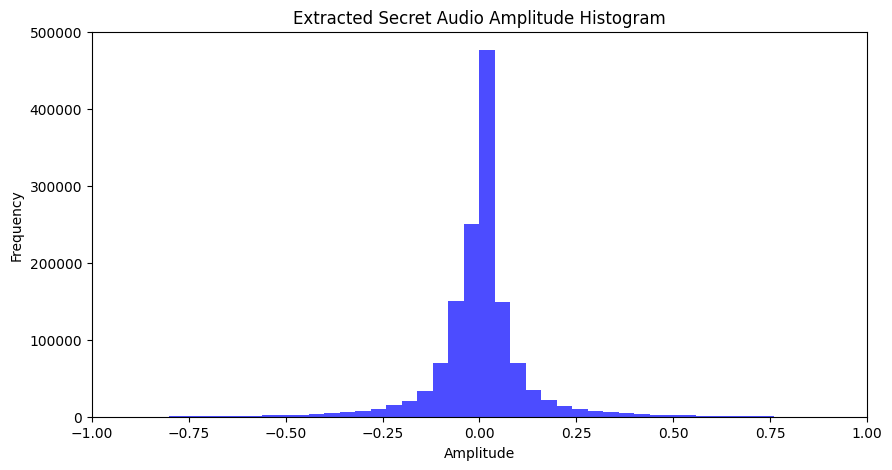

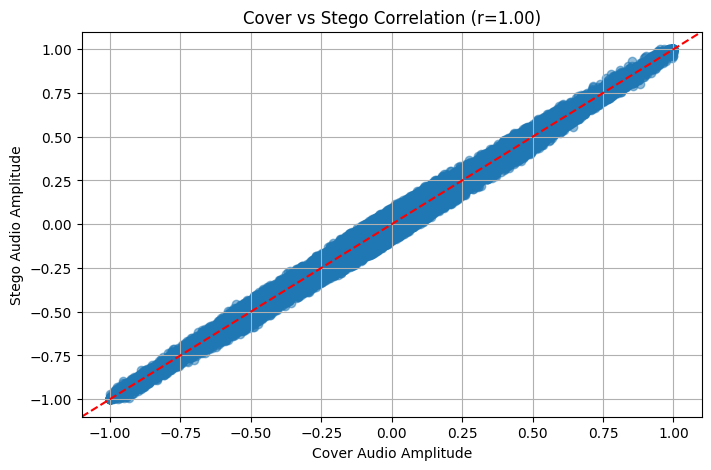

In [2]:
def main():
    # === Configuration ===
    TARGET_SAMPLE_RATE = 44100  # You can change this as needed

    # File paths
    cover_file = r'E:\Major_Project\Audio\DCT\Data\Baby laughing sound funny video on copyright.wav' # Replace with cover audio file path
    secret_file = r'E:\Major_Project\Audio\DCT\Data\TIGER ROAR SOUND IN HIGH QUALITY.wav'   # Replace with secret audio file path
    stego_file = 'stego_audio.wav'
    extracted_secret_file = 'extracted_secret.wav'

    # === Load Audio Files ===
    print("Loading audio files...")
    cover, sr_cover = load_audio(cover_file, target_sr=TARGET_SAMPLE_RATE)
    secret, sr_secret = load_audio(secret_file, target_sr=TARGET_SAMPLE_RATE)

    # === Ensure Both Audios Have the Same Number of Channels ===
    if cover.ndim > 1:
        cover = cover[:, 0]  # Take the first channel if stereo
    if secret.ndim > 1:
        secret = secret[:, 0]  # Take the first channel if stereo

    # === Ensure Secret is Not Longer Than Cover ===
    min_length = min(len(cover), len(secret))
    cover = cover[:min_length]
    secret = secret[:min_length]

    # === Embed Secret into Cover ===
    print("Embedding secret into cover...")
    stego = embed_secret_into_cover(cover, secret)

    # === Save Stego Audio ===
    print("Saving stego audio...")
    save_audio(stego_file, stego, TARGET_SAMPLE_RATE)

    # === Extract Secret from Stego ===
    print("Extracting secret from stego...")
    secret_extracted = extract_secret_from_stego(stego, cover)

    # === Save Extracted Secret ===
    print("Saving extracted secret audio...")
    save_audio(extracted_secret_file, secret_extracted, TARGET_SAMPLE_RATE)

    # === Calculate Metrics ===
    mse, snr = calculate_metrics(secret, secret_extracted[:len(secret)])  # Ensure same length for comparison
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Signal-to-Noise Ratio (SNR): {snr} dB')

    # === Plot Visualizations ===
    plot_waveforms(cover, stego, title1='Cover Audio', title2='Stego Audio')
    plot_waveforms(secret, secret_extracted[:len(secret)], title1='Original Secret', title2='Extracted Secret')  # Ensure same length
    plot_spectrogram(cover, sr_cover, title='Cover Audio Spectrogram')
    plot_spectrogram(stego, TARGET_SAMPLE_RATE, title='Stego Audio Spectrogram')
    plot_spectrogram(secret_extracted[:len(secret)], TARGET_SAMPLE_RATE, title='Extracted Secret Spectrogram')  # Ensure same length
    plot_rms(cover, stego, secret_extracted[:len(secret)])  # Ensure same length
    overlay_waveforms(cover, stego)
    plot_histogram(cover, title='Cover Audio Amplitude Histogram')
    plot_histogram(stego, title='Stego Audio Amplitude Histogram')
    plot_histogram(secret_extracted[:len(secret)], title='Extracted Secret Audio Amplitude Histogram')  # Ensure same length
    plot_correlation(cover, stego)

if __name__ == "__main__":
    main()



# MSE: Closer to zero is better.
# SNR: Higher values are better, with values above 30 dB being typically acceptable in audio applications. Values above 
# 43 dB indicate high quality.